In [1]:
from tensorflow import keras
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import sklearn.metrics
import h5py
import pandas as pd
import os
import os.path
import sys
import h5py
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model


2023-02-02 07:49:20.249610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 07:49:20.313937: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
TARGET_BYTE = 0 #何バイト目を攻撃するか決める

In [3]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [4]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [5]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [6]:
train_trace = train_trace[0:45000, 30824:31524]
test_trace = test_trace[45000:50000, 30824:31524]
attack_trace = attack_trace[50000:60000, 30824:31524]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [7]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [8]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [9]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [10]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [11]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [12]:
mlp_best()

2023-02-02 07:49:22.071532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 07:49:22.073410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 07:49:22.073512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 07:49:22.074160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [13]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=10
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

Epoch 1/10


2023-02-02 07:49:23.242922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-02 07:49:23.244175: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0233095dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-02 07:49:23.244193: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-02-02 07:49:23.246614: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-02 07:49:23.302235: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 [==============================] - 3s 7ms/step - loss: 5.5549 - accuracy: 0.0046 - val_loss: 5.5485 - val_accuracy: 0.0028
Epoch 2/10
225/225 [==============================] - 1s 6ms/step - loss: 5.5451 - accuracy: 0.0048 - val_loss: 5.5432 - val_accuracy: 0.0036
Epoch 3/10
225/225 [==============================] - 2s 7ms/step - loss: 5.5390 - accuracy: 0.0057 - val_loss: 5.5381 - val_accuracy: 0.0042
Epoch 4/10
225/225 [==============================] - 2s 7ms/step - loss: 5.5318 - accuracy: 0.0069 - val_loss: 5.5309 - val_accuracy: 0.0052
Epoch 5/10
225/225 [==============================] - 1s 4ms/step - loss: 5.5213 - accuracy: 0.0082 - val_loss: 5.5186 - val_accuracy: 0.0072
Epoch 6/10
225/225 [==============================] - 1s 6ms/step - loss: 5.5043 - accuracy: 0.0097 - val_loss: 5.4984 - val_accuracy: 0.0076
Epoch 7/10
225/225 [==============================] - 1s 6ms/step - loss: 5.4768 - accuracy: 0.0104 - val_loss: 5.4658 - val_accuracy: 0.0084
Epoch 8/10
225/22

In [14]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

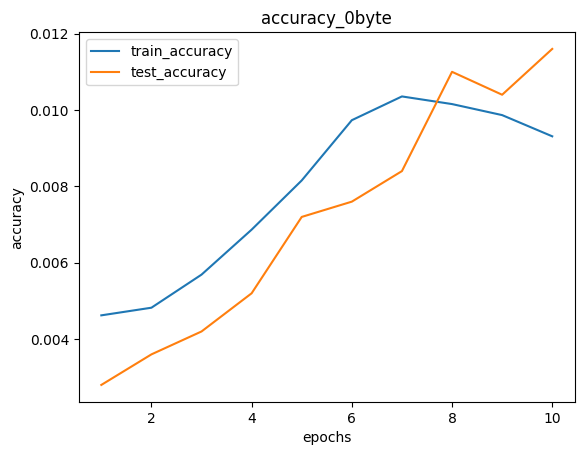

In [15]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [16]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 730us/step


TensorShape([10000, 256])

In [17]:
attack_plain=attack_metadata['plaintext']

In [18]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [19]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [20]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

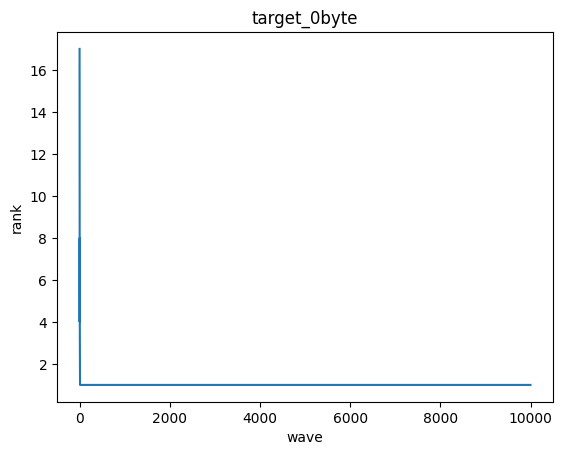

In [21]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [22]:
recovered_key0=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count0 = 1
        else:
            count0 = 0
        
        recovered_key0.append(count0) #攻撃成功バイト数の保存

recovered_key0 = np.array(recovered_key0)
np.save('./'+out+'/MLPtest0.npy', recovered_key0)

In [23]:
TARGET_BYTE = 1 #何バイト目を攻撃するか決める

In [24]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [25]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [26]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [27]:
train_trace = train_trace[0:45000, 24577:25277]
test_trace = test_trace[45000:50000, 24577:25277]
attack_trace = attack_trace[50000:60000, 24577:25277]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [28]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [29]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [30]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [31]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [32]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [33]:
mlp_best()

In [34]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=10
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=200,validation_data=(test_trace2,test_sbox_out))

Epoch 1/10
225/225 [==============================] - 1s 2ms/step - loss: 5.5560 - accuracy: 0.0041 - val_loss: 5.5534 - val_accuracy: 0.0036
Epoch 2/10
225/225 [==============================] - 1s 7ms/step - loss: 5.5473 - accuracy: 0.0039 - val_loss: 5.5491 - val_accuracy: 0.0046
Epoch 3/10
225/225 [==============================] - 1s 5ms/step - loss: 5.5425 - accuracy: 0.0040 - val_loss: 5.5459 - val_accuracy: 0.0042
Epoch 4/10
225/225 [==============================] - 1s 7ms/step - loss: 5.5377 - accuracy: 0.0045 - val_loss: 5.5419 - val_accuracy: 0.0052
Epoch 5/10
225/225 [==============================] - 1s 6ms/step - loss: 5.5315 - accuracy: 0.0051 - val_loss: 5.5358 - val_accuracy: 0.0056
Epoch 6/10
225/225 [==============================] - 1s 5ms/step - loss: 5.5224 - accuracy: 0.0062 - val_loss: 5.5260 - val_accuracy: 0.0076
Epoch 7/10
225/225 [==============================] - 1s 5ms/step - loss: 5.5073 - accuracy: 0.0092 - val_loss: 5.5088 - val_accuracy: 0.0088
Epoch 

In [35]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

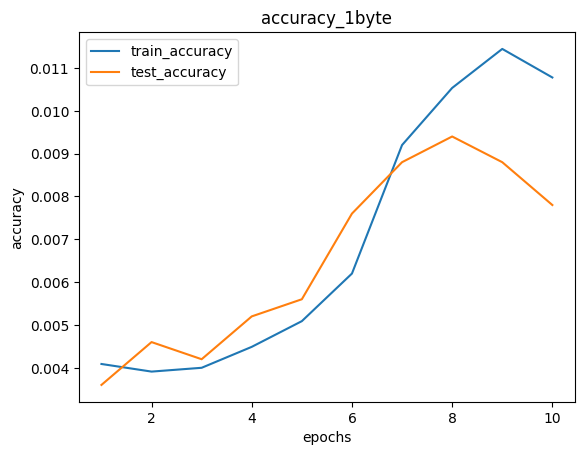

In [36]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [37]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 948us/step


TensorShape([10000, 256])

In [38]:
attack_plain=attack_metadata['plaintext']

In [39]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [40]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [41]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

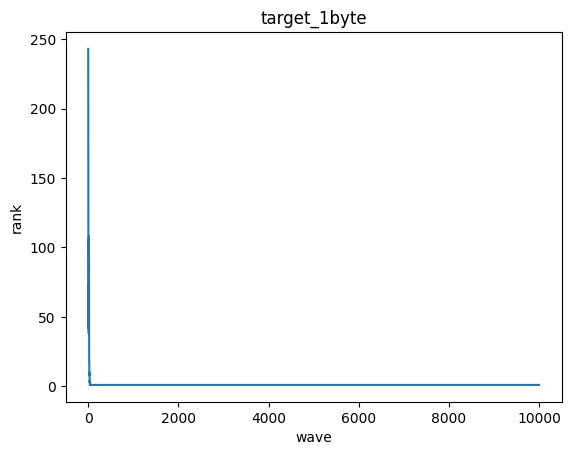

In [42]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [43]:
recovered_key1=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count1 = 1
        else:
            count1 = 0
        
        recovered_key1.append(count1) #攻撃成功バイト数の保存

recovered_key1 = np.array(recovered_key1)
np.save('./'+out+'/MLPtest1.npy', recovered_key1)

In [44]:
TARGET_BYTE = 2 #何バイト目を攻撃するか決める

In [45]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [46]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [47]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [48]:
train_trace = train_trace[0:45000, 45400:46100]
test_trace = test_trace[45000:50000, 45400:46100]
attack_trace = attack_trace[50000:60000, 45400:46100]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [49]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [50]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [51]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [52]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [53]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [54]:
mlp_best()

In [55]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 3s 5ms/step - loss: 5.5592 - accuracy: 0.0039 - val_loss: 5.5516 - val_accuracy: 0.0048
Epoch 2/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5495 - accuracy: 0.0044 - val_loss: 5.5487 - val_accuracy: 0.0050
Epoch 3/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5459 - accuracy: 0.0049 - val_loss: 5.5479 - val_accuracy: 0.0046
Epoch 4/200
450/450 [==============================] - 2s 5ms/step - loss: 5.5436 - accuracy: 0.0052 - val_loss: 5.5475 - val_accuracy: 0.0044
Epoch 5/200
450/450 [==============================] - 2s 5ms/step - loss: 5.5418 - accuracy: 0.0058 - val_loss: 5.5475 - val_accuracy: 0.0054
Epoch 6/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5403 - accuracy: 0.0057 - val_loss: 5.5473 - val_accuracy: 0.0050
Epoch 7/200
450/450 [==============================] - 2s 5ms/step - loss: 5.5389 - accuracy: 0.0063 - val_loss: 5.5473 - val_accuracy: 0.0052

In [56]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

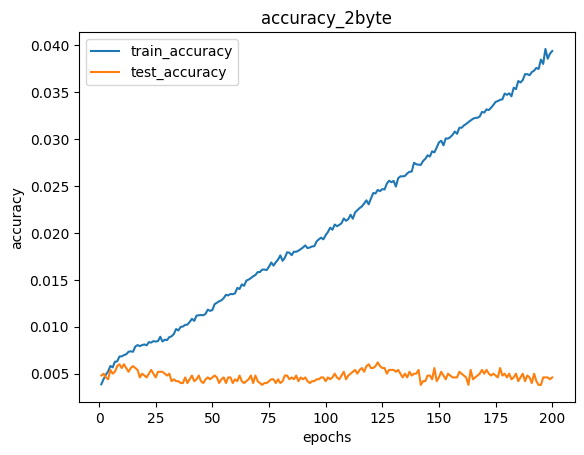

In [57]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [58]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 870us/step


TensorShape([10000, 256])

In [59]:
attack_plain=attack_metadata['plaintext']

In [60]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [61]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [62]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

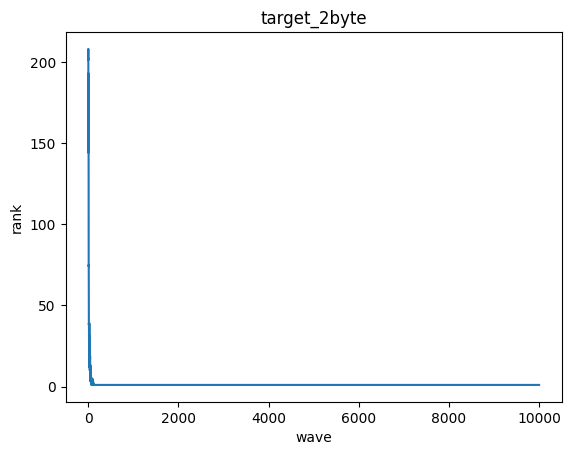

In [63]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [64]:
recovered_key2=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count2 = 1
        else:
            count2 = 0
        
        recovered_key2.append(count2) #攻撃成功バイト数の保存

recovered_key2 = np.array(recovered_key2)
np.save('./'+out+'/MLPtest2.npy', recovered_key2)

In [65]:
TARGET_BYTE = 3 #何バイト目を攻撃するか決める

In [66]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [67]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [68]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [69]:
train_trace = train_trace[0:45000, 32906:33606]
test_trace = test_trace[45000:50000, 32906:33606]
attack_trace = attack_trace[50000:60000, 32906:33606]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [70]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [71]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [72]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [73]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [74]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [75]:
mlp_best()

In [76]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 3s 5ms/step - loss: 5.5576 - accuracy: 0.0035 - val_loss: 5.5511 - val_accuracy: 0.0038
Epoch 2/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5487 - accuracy: 0.0040 - val_loss: 5.5492 - val_accuracy: 0.0044
Epoch 3/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5452 - accuracy: 0.0043 - val_loss: 5.5485 - val_accuracy: 0.0050
Epoch 4/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5430 - accuracy: 0.0046 - val_loss: 5.5479 - val_accuracy: 0.0044
Epoch 5/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5411 - accuracy: 0.0051 - val_loss: 5.5476 - val_accuracy: 0.0048
Epoch 6/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5393 - accuracy: 0.0054 - val_loss: 5.5473 - val_accuracy: 0.0048
Epoch 7/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5377 - accuracy: 0.0058 - val_loss: 5.5472 - val_accuracy: 0.0034

In [77]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

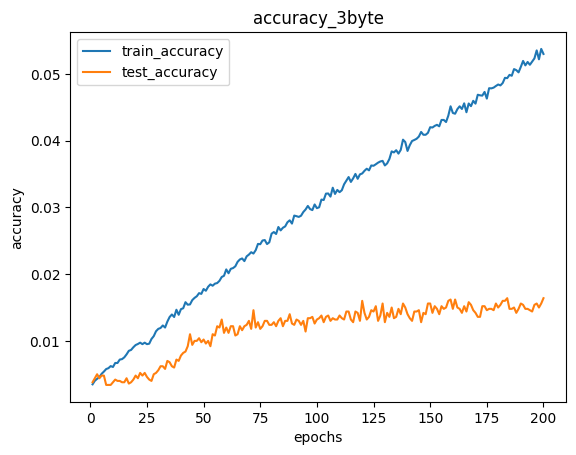

In [78]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [79]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 546us/step


TensorShape([10000, 256])

In [80]:
attack_plain=attack_metadata['plaintext']

In [81]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [82]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [83]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

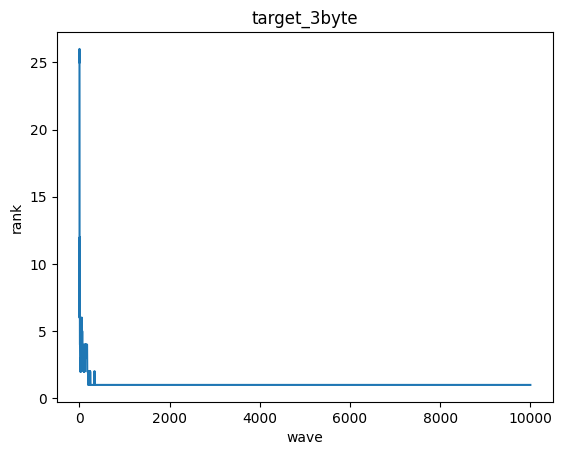

In [84]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [85]:
recovered_key3=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count3 = 1
        else:
            count3 = 0
        
        recovered_key3.append(count3) #攻撃成功バイト数の保存

recovered_key3 = np.array(recovered_key3)
np.save('./'+out+'/MLPtest3.npy', recovered_key3)

In [86]:
TARGET_BYTE = 4 #何バイト目を攻撃するか決める

In [87]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [88]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [89]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [90]:
train_trace = train_trace[0:45000, 47482:48182]
test_trace = test_trace[45000:50000, 47482:48182]
attack_trace = attack_trace[50000:60000, 47482:48182]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [91]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [92]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [93]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [94]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [95]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [96]:
mlp_best()

In [97]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5584 - accuracy: 0.0043 - val_loss: 5.5550 - val_accuracy: 0.0050
Epoch 2/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5492 - accuracy: 0.0048 - val_loss: 5.5519 - val_accuracy: 0.0044
Epoch 3/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5456 - accuracy: 0.0051 - val_loss: 5.5509 - val_accuracy: 0.0032
Epoch 4/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5434 - accuracy: 0.0050 - val_loss: 5.5506 - val_accuracy: 0.0036
Epoch 5/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5417 - accuracy: 0.0053 - val_loss: 5.5503 - val_accuracy: 0.0036
Epoch 6/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5401 - accuracy: 0.0055 - val_loss: 5.5501 - val_accuracy: 0.0036
Epoch 7/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5387 - accuracy: 0.0062 - val_loss: 5.5502 - val_accuracy: 0.0040

In [98]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

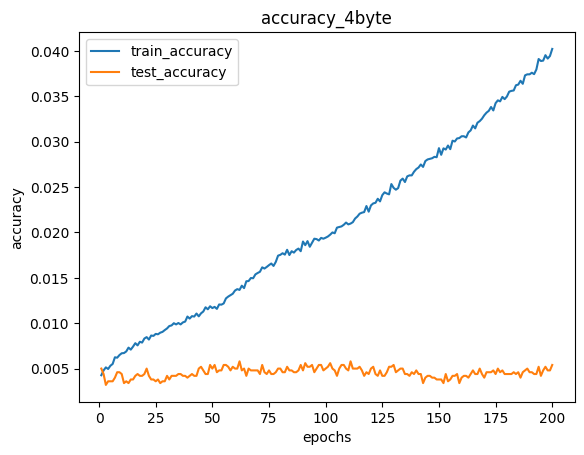

In [99]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [100]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 517us/step


TensorShape([10000, 256])

In [101]:
attack_plain=attack_metadata['plaintext']

In [102]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [103]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [104]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

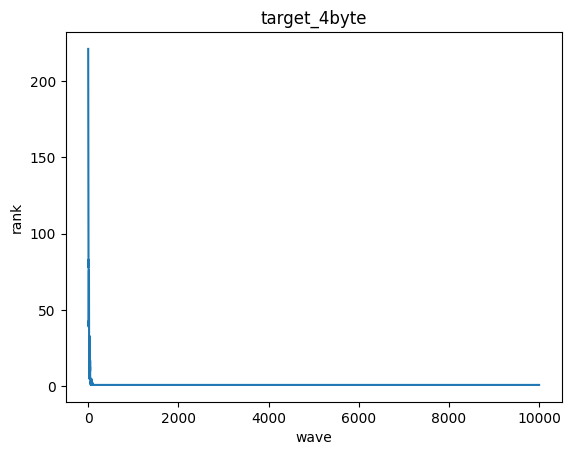

In [105]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [106]:
recovered_key4=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count4 = 1
        else:
            count4 = 0
        
        recovered_key4.append(count4) #攻撃成功バイト数の保存

recovered_key4 = np.array(recovered_key4)
np.save('./'+out+'/MLPtest4.npy', recovered_key4)

In [107]:
TARGET_BYTE = 5 #何バイト目を攻撃するか決める

In [108]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [109]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [110]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [111]:
train_trace = train_trace[0:45000, 41235:41935]
test_trace = test_trace[45000:50000, 41235:41935]
attack_trace = attack_trace[50000:60000, 41235:41935]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [112]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [113]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [114]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [115]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [116]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [117]:
mlp_best()

In [118]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5573 - accuracy: 0.0037 - val_loss: 5.5519 - val_accuracy: 0.0036
Epoch 2/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5489 - accuracy: 0.0040 - val_loss: 5.5498 - val_accuracy: 0.0036
Epoch 3/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5456 - accuracy: 0.0044 - val_loss: 5.5490 - val_accuracy: 0.0042
Epoch 4/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5435 - accuracy: 0.0047 - val_loss: 5.5485 - val_accuracy: 0.0034
Epoch 5/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5417 - accuracy: 0.0044 - val_loss: 5.5481 - val_accuracy: 0.0030
Epoch 6/200
450/450 [==============================] - 2s 5ms/step - loss: 5.5402 - accuracy: 0.0048 - val_loss: 5.5478 - val_accuracy: 0.0030
Epoch 7/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5387 - accuracy: 0.0050 - val_loss: 5.5478 - val_accuracy: 0.0032

In [119]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

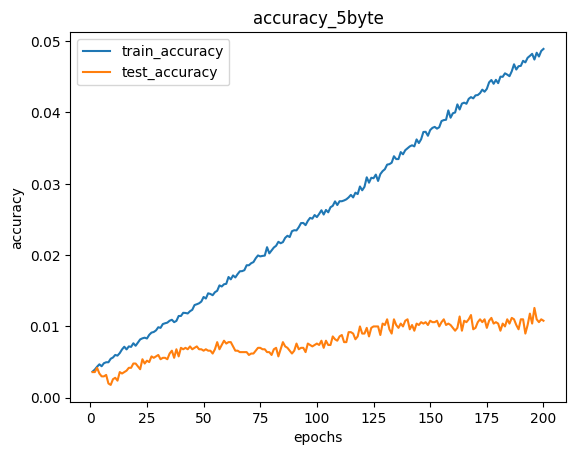

In [120]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [121]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 498us/step


TensorShape([10000, 256])

In [122]:
attack_plain=attack_metadata['plaintext']

In [123]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [124]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [125]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

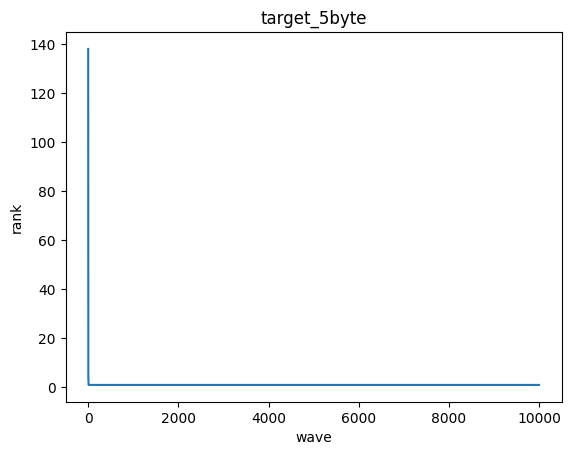

In [126]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [127]:
recovered_key5=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count5 = 1
        else:
            count5 = 0
        
        recovered_key5.append(count5) #攻撃成功バイト数の保存

recovered_key5 = np.array(recovered_key5)
np.save('./'+out+'/MLPtest5.npy', recovered_key5)

In [128]:
TARGET_BYTE = 6 #何バイト目を攻撃するか決める

In [129]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [130]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [131]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [132]:
train_trace = train_trace[0:45000, 37071:37771]
test_trace = test_trace[45000:50000, 37071:37771]
attack_trace = attack_trace[50000:60000, 37071:37771]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [133]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [134]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [135]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [136]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [137]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [138]:
mlp_best()

In [139]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5589 - accuracy: 0.0040 - val_loss: 5.5534 - val_accuracy: 0.0026
Epoch 2/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5499 - accuracy: 0.0037 - val_loss: 5.5506 - val_accuracy: 0.0028
Epoch 3/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5467 - accuracy: 0.0042 - val_loss: 5.5498 - val_accuracy: 0.0028
Epoch 4/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5446 - accuracy: 0.0044 - val_loss: 5.5492 - val_accuracy: 0.0028
Epoch 5/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5430 - accuracy: 0.0047 - val_loss: 5.5491 - val_accuracy: 0.0028
Epoch 6/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5416 - accuracy: 0.0051 - val_loss: 5.5490 - val_accuracy: 0.0026
Epoch 7/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5403 - accuracy: 0.0054 - val_loss: 5.5490 - val_accuracy: 0.0018

In [140]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

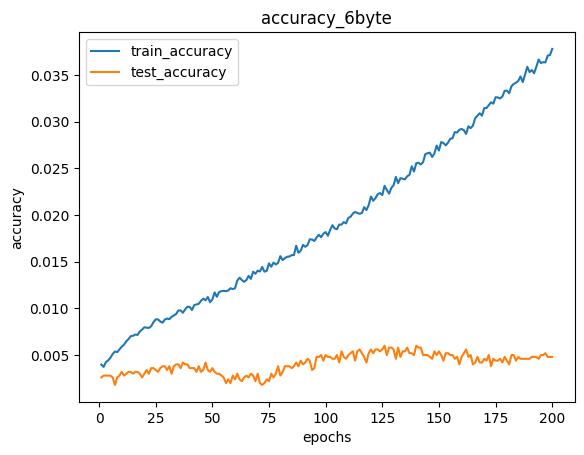

In [141]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [142]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 496us/step


TensorShape([10000, 256])

In [143]:
attack_plain=attack_metadata['plaintext']

In [144]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [145]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [146]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

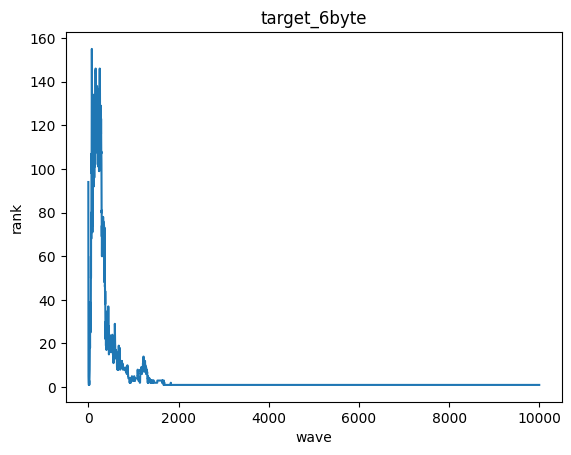

In [147]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [148]:
recovered_key6=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count6 = 1
        else:
            count6 = 0
        
        recovered_key6.append(count6) #攻撃成功バイト数の保存

recovered_key6 = np.array(recovered_key6)
np.save('./'+out+'/MLPtest6.npy', recovered_key6)

In [149]:
TARGET_BYTE = 7 #何バイト目を攻撃するか決める

In [150]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [151]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [152]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [153]:
train_trace = train_trace[0:45000, 34989:35689]
test_trace = test_trace[45000:50000, 34989:35689]
attack_trace = attack_trace[50000:60000, 34989:35689]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [154]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [155]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [156]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [157]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [158]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [159]:
mlp_best()

In [160]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5567 - accuracy: 0.0041 - val_loss: 5.5510 - val_accuracy: 0.0032
Epoch 2/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5484 - accuracy: 0.0040 - val_loss: 5.5488 - val_accuracy: 0.0030
Epoch 3/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5455 - accuracy: 0.0043 - val_loss: 5.5481 - val_accuracy: 0.0034
Epoch 4/200
450/450 [==============================] - 2s 4ms/step - loss: 5.5436 - accuracy: 0.0046 - val_loss: 5.5479 - val_accuracy: 0.0036
Epoch 5/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5422 - accuracy: 0.0052 - val_loss: 5.5478 - val_accuracy: 0.0030
Epoch 6/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5408 - accuracy: 0.0055 - val_loss: 5.5477 - val_accuracy: 0.0028
Epoch 7/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5396 - accuracy: 0.0053 - val_loss: 5.5477 - val_accuracy: 0.0028

In [161]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

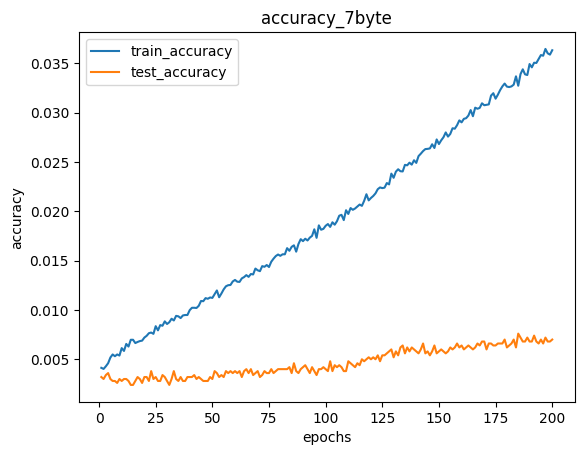

In [162]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [163]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 890us/step


TensorShape([10000, 256])

In [164]:
attack_plain=attack_metadata['plaintext']

In [165]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [166]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [167]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

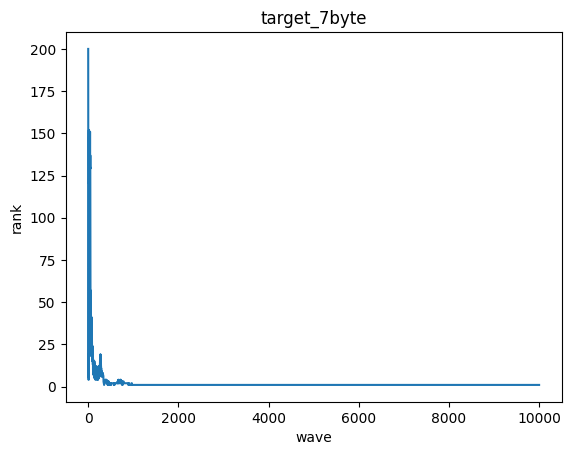

In [168]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [169]:
recovered_key7=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count7 = 1
        else:
            count7 = 0
        
        recovered_key7.append(count7) #攻撃成功バイト数の保存

recovered_key7 = np.array(recovered_key7)
np.save('./'+out+'/MLPtest7.npy', recovered_key7)

In [170]:
TARGET_BYTE = 8 #何バイト目を攻撃するか決める

In [171]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [172]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [173]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [174]:
train_trace = train_trace[0:45000, 26660:27360]
test_trace = test_trace[45000:50000, 26660:27360]
attack_trace = attack_trace[50000:60000, 26660:27360]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [175]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [176]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [177]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [178]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [179]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [180]:
mlp_best()

In [181]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5554 - accuracy: 0.0041 - val_loss: 5.5527 - val_accuracy: 0.0034
Epoch 2/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5486 - accuracy: 0.0042 - val_loss: 5.5505 - val_accuracy: 0.0032
Epoch 3/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5459 - accuracy: 0.0046 - val_loss: 5.5497 - val_accuracy: 0.0030
Epoch 4/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5440 - accuracy: 0.0050 - val_loss: 5.5491 - val_accuracy: 0.0028
Epoch 5/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5425 - accuracy: 0.0049 - val_loss: 5.5489 - val_accuracy: 0.0036
Epoch 6/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5412 - accuracy: 0.0052 - val_loss: 5.5488 - val_accuracy: 0.0034
Epoch 7/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5399 - accuracy: 0.0056 - val_loss: 5.5488 - val_accuracy: 0.0040

In [182]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

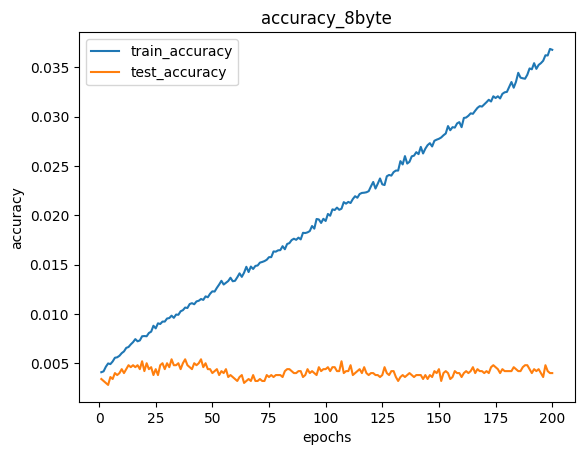

In [183]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [184]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 1ms/step


TensorShape([10000, 256])

In [185]:
attack_plain=attack_metadata['plaintext']

In [186]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [187]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [188]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

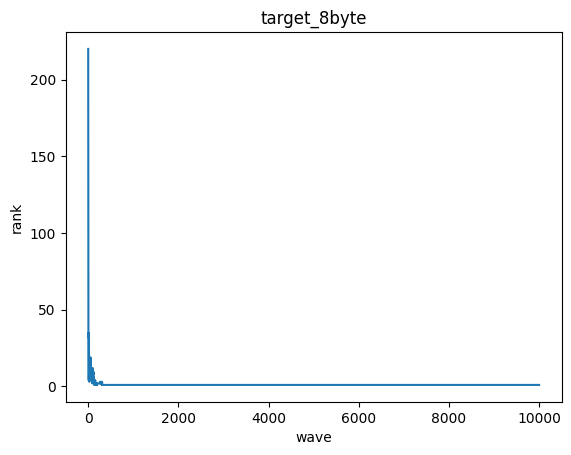

In [189]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [190]:
recovered_key8=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count8 = 1
        else:
            count8 = 0
        
        recovered_key8.append(count8) #攻撃成功バイト数の保存

recovered_key8 = np.array(recovered_key8)
np.save('./'+out+'/MLPtest8.npy', recovered_key8)

In [191]:
TARGET_BYTE = 9 #何バイト目を攻撃するか決める

In [192]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [193]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [194]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [195]:
train_trace = train_trace[0:45000, 39154:39854]
test_trace = test_trace[45000:50000, 39154:39854]
attack_trace = attack_trace[50000:60000, 39154:39854]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [196]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [197]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [198]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [199]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [200]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [201]:
mlp_best()

In [202]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5559 - accuracy: 0.0041 - val_loss: 5.5539 - val_accuracy: 0.0024
Epoch 2/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5487 - accuracy: 0.0043 - val_loss: 5.5514 - val_accuracy: 0.0038
Epoch 3/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5458 - accuracy: 0.0041 - val_loss: 5.5506 - val_accuracy: 0.0034
Epoch 4/200
450/450 [==============================] - 2s 6ms/step - loss: 5.5439 - accuracy: 0.0042 - val_loss: 5.5498 - val_accuracy: 0.0034
Epoch 5/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5424 - accuracy: 0.0044 - val_loss: 5.5497 - val_accuracy: 0.0030
Epoch 6/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5411 - accuracy: 0.0048 - val_loss: 5.5496 - val_accuracy: 0.0032
Epoch 7/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5398 - accuracy: 0.0050 - val_loss: 5.5496 - val_accuracy: 0.0026

In [203]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

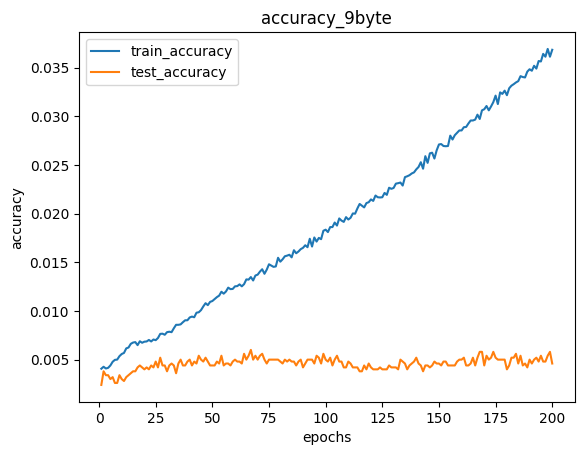

In [204]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [205]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 714us/step


TensorShape([10000, 256])

In [206]:
attack_plain=attack_metadata['plaintext']

In [207]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [208]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [209]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

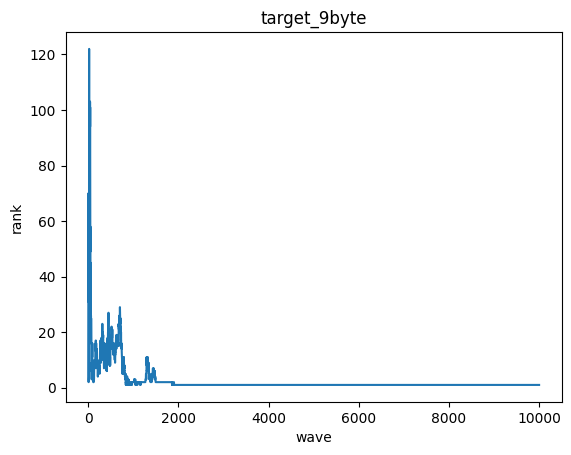

In [210]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [211]:
recovered_key9=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count9 = 1
        else:
            count9 = 0
        
        recovered_key9.append(count9) #攻撃成功バイト数の保存

recovered_key9 = np.array(recovered_key9)
np.save('./'+out+'/MLPtest9.npy', recovered_key9)

In [212]:
TARGET_BYTE = 10 #何バイト目を攻撃するか決める

In [213]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [214]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [215]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [216]:
train_trace = train_trace[0:45000, 28742:29442]
test_trace = test_trace[45000:50000, 28742:29442]
attack_trace = attack_trace[50000:60000, 28742:29442]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [217]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [218]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [219]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [220]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [221]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [222]:
mlp_best()

In [223]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5558 - accuracy: 0.0037 - val_loss: 5.5491 - val_accuracy: 0.0030
Epoch 2/200
450/450 [==============================] - 2s 4ms/step - loss: 5.5488 - accuracy: 0.0047 - val_loss: 5.5475 - val_accuracy: 0.0038
Epoch 3/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5461 - accuracy: 0.0045 - val_loss: 5.5468 - val_accuracy: 0.0038
Epoch 4/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5442 - accuracy: 0.0048 - val_loss: 5.5466 - val_accuracy: 0.0040
Epoch 5/200
450/450 [==============================] - 2s 4ms/step - loss: 5.5427 - accuracy: 0.0051 - val_loss: 5.5463 - val_accuracy: 0.0040
Epoch 6/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5414 - accuracy: 0.0054 - val_loss: 5.5460 - val_accuracy: 0.0044
Epoch 7/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5402 - accuracy: 0.0055 - val_loss: 5.5460 - val_accuracy: 0.0042

In [224]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

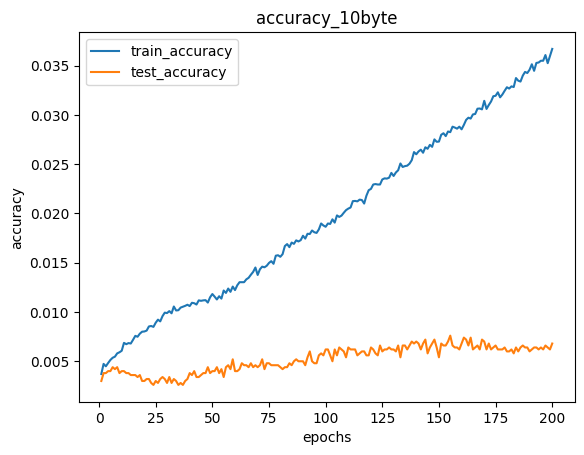

In [225]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [226]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 570us/step


TensorShape([10000, 256])

In [227]:
attack_plain=attack_metadata['plaintext']

In [228]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [229]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [230]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

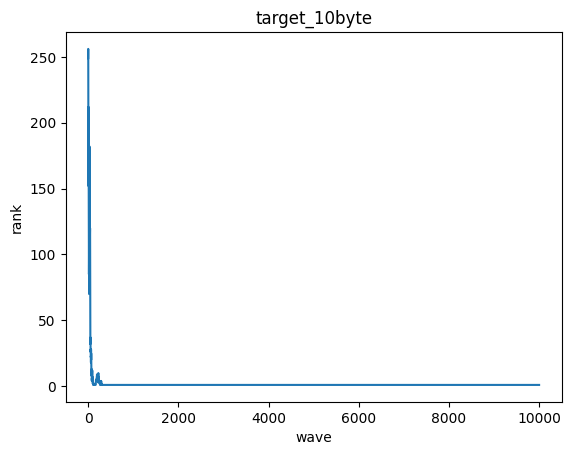

In [231]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [232]:
recovered_key10=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count10 = 1
        else:
            count10 = 0
        
        recovered_key10.append(count10) #攻撃成功バイト数の保存

recovered_key10 = np.array(recovered_key10)
np.save('./'+out+'/MLPtest10.npy', recovered_key10)

In [233]:
TARGET_BYTE = 11 #何バイト目を攻撃するか決める

In [234]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [235]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [236]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [237]:
train_trace = train_trace[0:45000, 43318:44018]
test_trace = test_trace[45000:50000, 43318:44018]
attack_trace = attack_trace[50000:60000, 43318:44018]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [238]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [239]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [240]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [241]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [242]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [243]:
mlp_best()

In [244]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 4s 6ms/step - loss: 5.5535 - accuracy: 0.0034 - val_loss: 5.5546 - val_accuracy: 0.0040
Epoch 2/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5478 - accuracy: 0.0037 - val_loss: 5.5523 - val_accuracy: 0.0042
Epoch 3/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5453 - accuracy: 0.0036 - val_loss: 5.5512 - val_accuracy: 0.0044
Epoch 4/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5435 - accuracy: 0.0040 - val_loss: 5.5505 - val_accuracy: 0.0052
Epoch 5/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5422 - accuracy: 0.0041 - val_loss: 5.5503 - val_accuracy: 0.0052
Epoch 6/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5409 - accuracy: 0.0046 - val_loss: 5.5503 - val_accuracy: 0.0056
Epoch 7/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5398 - accuracy: 0.0046 - val_loss: 5.5504 - val_accuracy: 0.0050

In [245]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

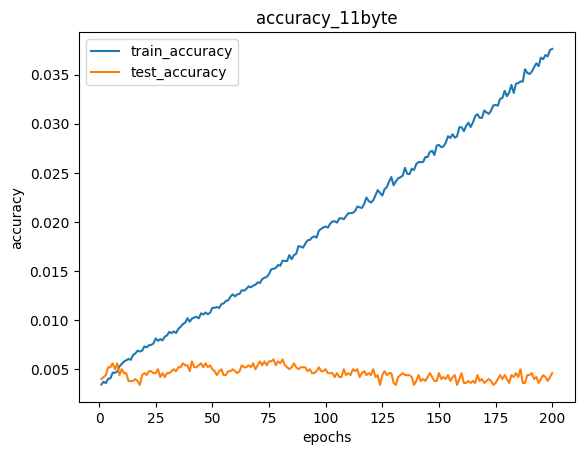

In [246]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [247]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 525us/step


TensorShape([10000, 256])

In [248]:
attack_plain=attack_metadata['plaintext']

In [249]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [250]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [251]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

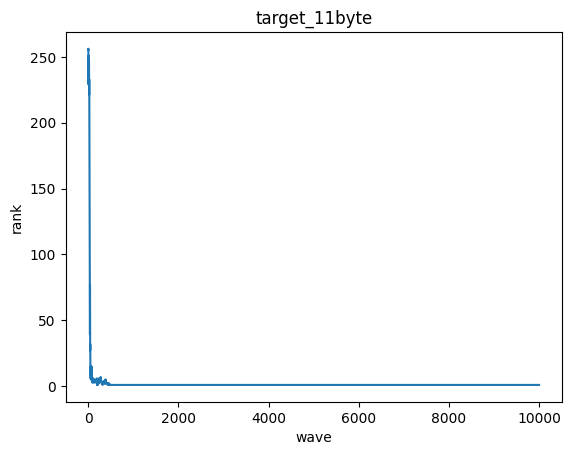

In [252]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [253]:
recovered_key11=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count11 = 1
        else:
            count11 = 0
        
        recovered_key11.append(count11) #攻撃成功バイト数の保存

recovered_key11 = np.array(recovered_key11)
np.save('./'+out+'/MLPtest11.npy', recovered_key11)

In [254]:
TARGET_BYTE = 12 #何バイト目を攻撃するか決める

In [255]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [256]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [257]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [258]:
train_trace = train_trace[0:45000, 20413:21113]
test_trace = test_trace[45000:50000, 20413:21113]
attack_trace = attack_trace[50000:60000, 20413:21113]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [259]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [260]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [261]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [262]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [263]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [264]:
mlp_best()

In [265]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 4s 7ms/step - loss: 5.5550 - accuracy: 0.0039 - val_loss: 5.5513 - val_accuracy: 0.0034
Epoch 2/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5483 - accuracy: 0.0042 - val_loss: 5.5491 - val_accuracy: 0.0042
Epoch 3/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5456 - accuracy: 0.0046 - val_loss: 5.5485 - val_accuracy: 0.0042
Epoch 4/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5437 - accuracy: 0.0048 - val_loss: 5.5481 - val_accuracy: 0.0042
Epoch 5/200
450/450 [==============================] - 2s 6ms/step - loss: 5.5422 - accuracy: 0.0050 - val_loss: 5.5479 - val_accuracy: 0.0044
Epoch 6/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5408 - accuracy: 0.0055 - val_loss: 5.5480 - val_accuracy: 0.0036
Epoch 7/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5396 - accuracy: 0.0059 - val_loss: 5.5482 - val_accuracy: 0.0038

In [266]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

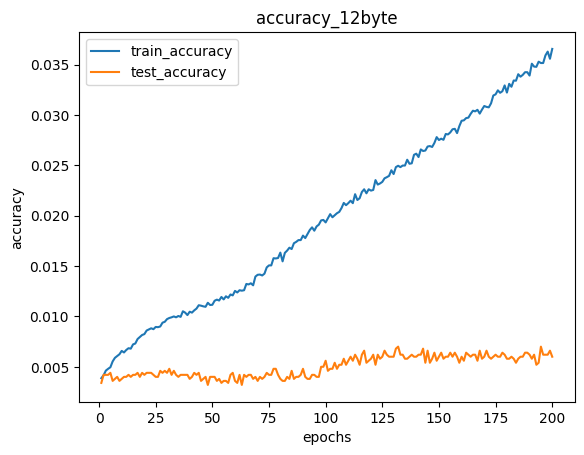

In [267]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [268]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 712us/step


TensorShape([10000, 256])

In [269]:
attack_plain=attack_metadata['plaintext']

In [270]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [271]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [272]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

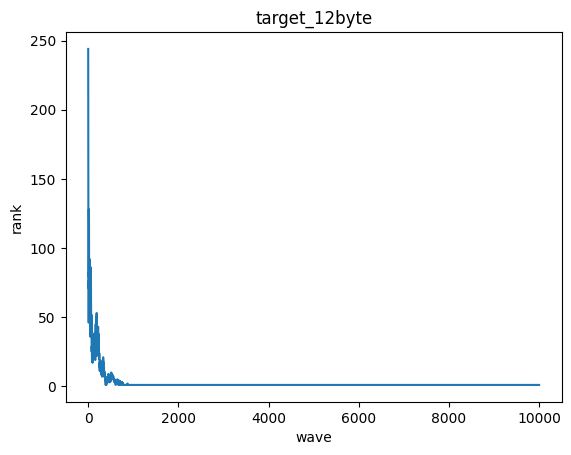

In [273]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [274]:
recovered_key12=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count12 = 1
        else:
            count12 = 0
        
        recovered_key12.append(count12) #攻撃成功バイト数の保存

recovered_key12 = np.array(recovered_key12)
np.save('./'+out+'/MLPtest12.npy', recovered_key12)

In [275]:
TARGET_BYTE = 13 #何バイト目を攻撃するか決める

In [276]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [277]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [278]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [279]:
train_trace = train_trace[0:45000, 22495:23195]
test_trace = test_trace[45000:50000, 22495:23195]
attack_trace = attack_trace[50000:60000, 22495:23195]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [280]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [281]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [282]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [283]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [284]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [285]:
mlp_best()

In [286]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 4s 7ms/step - loss: 5.5550 - accuracy: 0.0039 - val_loss: 5.5545 - val_accuracy: 0.0042
Epoch 2/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5480 - accuracy: 0.0041 - val_loss: 5.5524 - val_accuracy: 0.0040
Epoch 3/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5453 - accuracy: 0.0042 - val_loss: 5.5516 - val_accuracy: 0.0042
Epoch 4/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5434 - accuracy: 0.0042 - val_loss: 5.5511 - val_accuracy: 0.0046
Epoch 5/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5418 - accuracy: 0.0044 - val_loss: 5.5510 - val_accuracy: 0.0046
Epoch 6/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5405 - accuracy: 0.0044 - val_loss: 5.5509 - val_accuracy: 0.0044
Epoch 7/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5393 - accuracy: 0.0044 - val_loss: 5.5508 - val_accuracy: 0.0052

In [287]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

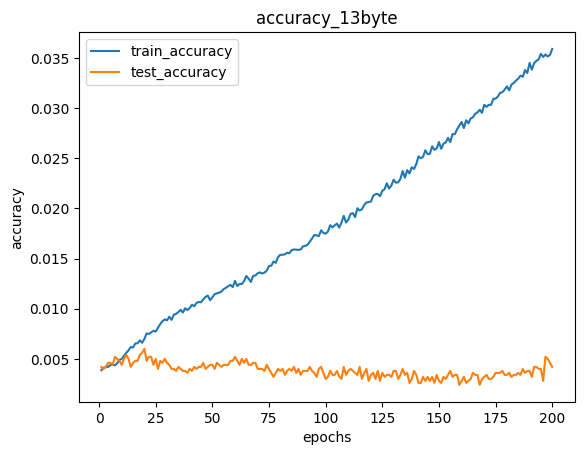

In [288]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [289]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 514us/step


TensorShape([10000, 256])

In [290]:
attack_plain=attack_metadata['plaintext']

In [291]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [292]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [293]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

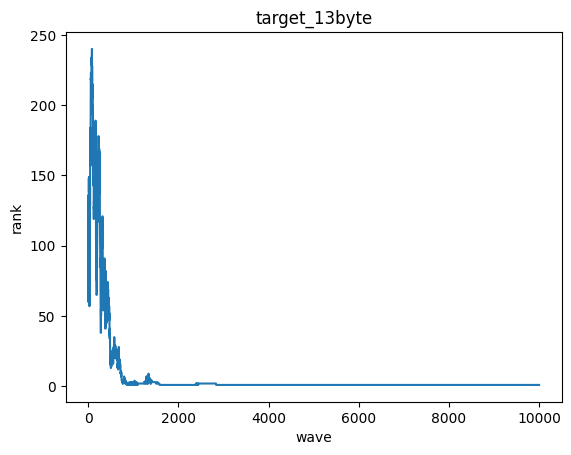

In [294]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [295]:
recovered_key13=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count13 = 1
        else:
            count13 = 0
        
        recovered_key13.append(count13) #攻撃成功バイト数の保存

recovered_key13 = np.array(recovered_key13)
np.save('./'+out+'/MLPtest13.npy', recovered_key13)

In [296]:
TARGET_BYTE = 14 #何バイト目を攻撃するか決める

In [297]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [298]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [299]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [300]:
train_trace = train_trace[0:45000, 49565:50265]
test_trace = test_trace[45000:50000, 49565:50265]
attack_trace = attack_trace[50000:60000, 49565:50265]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [301]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [302]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [303]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [304]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [305]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [306]:
mlp_best()

In [307]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 4s 7ms/step - loss: 5.5544 - accuracy: 0.0042 - val_loss: 5.5512 - val_accuracy: 0.0038
Epoch 2/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5483 - accuracy: 0.0045 - val_loss: 5.5495 - val_accuracy: 0.0038
Epoch 3/200
450/450 [==============================] - 2s 4ms/step - loss: 5.5456 - accuracy: 0.0042 - val_loss: 5.5488 - val_accuracy: 0.0036
Epoch 4/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5437 - accuracy: 0.0047 - val_loss: 5.5485 - val_accuracy: 0.0034
Epoch 5/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5421 - accuracy: 0.0047 - val_loss: 5.5483 - val_accuracy: 0.0034
Epoch 6/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5408 - accuracy: 0.0049 - val_loss: 5.5482 - val_accuracy: 0.0034
Epoch 7/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5395 - accuracy: 0.0050 - val_loss: 5.5482 - val_accuracy: 0.0036

In [308]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

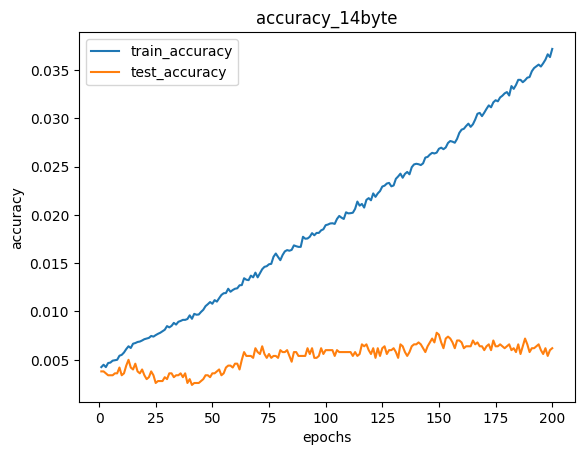

In [309]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [310]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 760us/step


TensorShape([10000, 256])

In [311]:
attack_plain=attack_metadata['plaintext']

In [312]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [313]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [314]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

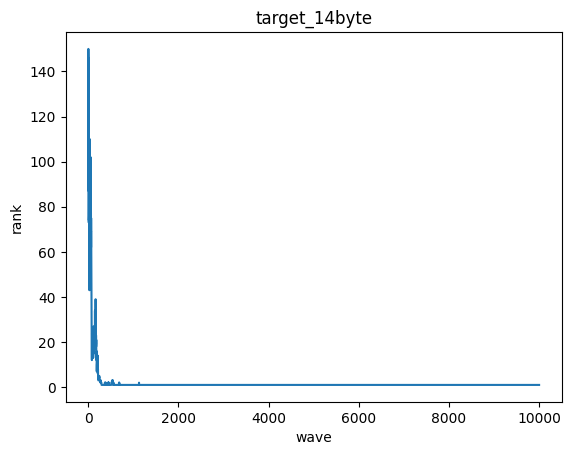

In [315]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [316]:
recovered_key14=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count14 = 1
        else:
            count14 = 0
        
        recovered_key14.append(count14) #攻撃成功バイト数の保存

recovered_key14 = np.array(recovered_key14)
np.save('./'+out+'/MLPtest14.npy', recovered_key14)

In [317]:
TARGET_BYTE = 15 #何バイト目を攻撃するか決める

In [318]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [319]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [320]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [321]:
train_trace = train_trace[0:45000, 18330:19030]
test_trace = test_trace[45000:50000, 18330:19030]
attack_trace = attack_trace[50000:60000, 18330:19030]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [322]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [323]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [324]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [325]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [326]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [327]:
mlp_best()

In [328]:
model=mlp_best(node=200,layer_nb=6,input_dim=700)
epochs=200
learning_data = model.fit(train_trace2,train_sbox_out,epochs=epochs,batch_size=100,validation_data=(test_trace2,test_sbox_out))

Epoch 1/200
450/450 [==============================] - 3s 6ms/step - loss: 5.5575 - accuracy: 0.0043 - val_loss: 5.5543 - val_accuracy: 0.0052
Epoch 2/200
450/450 [==============================] - 2s 5ms/step - loss: 5.5492 - accuracy: 0.0047 - val_loss: 5.5512 - val_accuracy: 0.0058
Epoch 3/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5462 - accuracy: 0.0044 - val_loss: 5.5501 - val_accuracy: 0.0052
Epoch 4/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5440 - accuracy: 0.0047 - val_loss: 5.5494 - val_accuracy: 0.0052
Epoch 5/200
450/450 [==============================] - 2s 4ms/step - loss: 5.5424 - accuracy: 0.0050 - val_loss: 5.5488 - val_accuracy: 0.0048
Epoch 6/200
450/450 [==============================] - 2s 3ms/step - loss: 5.5409 - accuracy: 0.0052 - val_loss: 5.5485 - val_accuracy: 0.0046
Epoch 7/200
450/450 [==============================] - 3s 7ms/step - loss: 5.5396 - accuracy: 0.0055 - val_loss: 5.5484 - val_accuracy: 0.0044

In [329]:
out = 'result'

os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

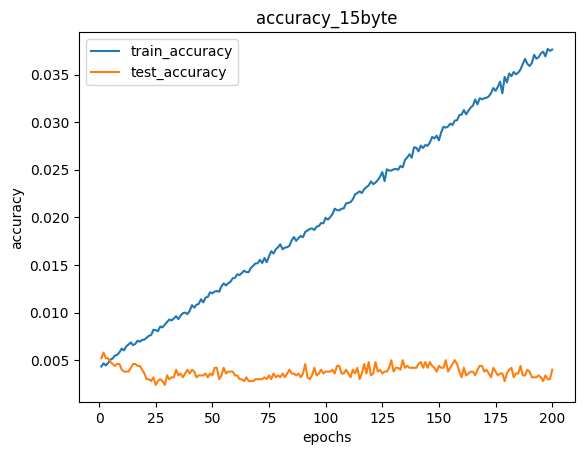

In [330]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

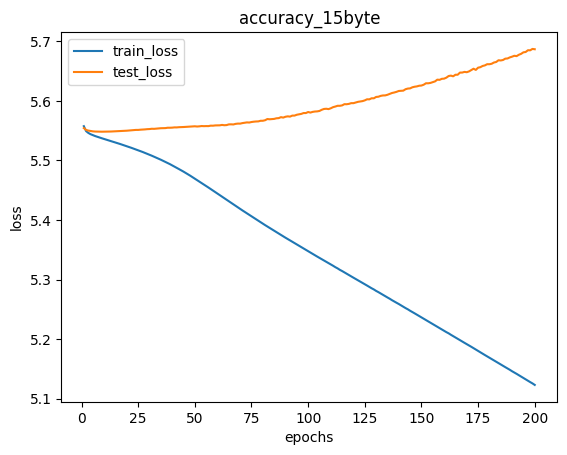

In [331]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['loss'], label = 'train_loss')
plt.plot(range(1,epochs+1), learning_data.history['val_loss'], label = 'test_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [332]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 965us/step


TensorShape([10000, 256])

In [333]:
attack_plain=attack_metadata['plaintext']

In [334]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [335]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [336]:
result = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result *= pred[i, attack_sbox_out[:, i]]
    result = result /np.sum(result)
    rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

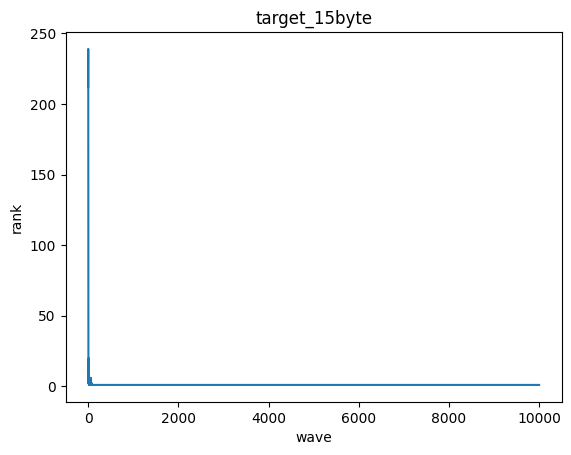

In [337]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))
plt.savefig('./'+out+'/compare_rank_{}byte.png'.format(TARGET_BYTE))

In [338]:
recovered_key15=[]

for i in range(10000):
        if rank[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count15 = 1
        else:
            count15 = 0
        
        recovered_key15.append(count15) #攻撃成功バイト数の保存

recovered_key15 = np.array(recovered_key15)
np.save('./'+out+'/MLPtest15.npy', recovered_key15)

In [339]:
from matplotlib.ticker import MaxNLocator

(0.0, 17.0)

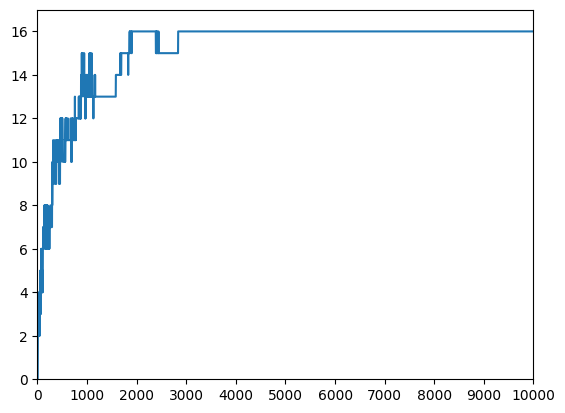

In [348]:
recovered_key0 = np.load('MLPtest0.npy')
recovered_key1 = np.load('MLPtest1.npy')
recovered_key2 = np.load('MLPtest2.npy')
recovered_key3 = np.load('MLPtest3.npy')
recovered_key4 = np.load('MLPtest4.npy')
recovered_key5 = np.load('MLPtest5.npy')
recovered_key6 = np.load('MLPtest6.npy')
recovered_key7 = np.load('MLPtest7.npy')
recovered_key8 = np.load('MLPtest8.npy')
recovered_key9 = np.load('MLPtest9.npy')
recovered_key10 = np.load('MLPtest10.npy')
recovered_key11 = np.load('MLPtest11.npy')
recovered_key12 = np.load('MLPtest12.npy')
recovered_key13 = np.load('MLPtest13.npy')
recovered_key14 = np.load('MLPtest14.npy')
recovered_key15 = np.load('MLPtest15.npy')

A = recovered_key0 + recovered_key1 + recovered_key2 + recovered_key3 + recovered_key4 + recovered_key5 + recovered_key6 + recovered_key7 + recovered_key8 + recovered_key9 + recovered_key10 + recovered_key11 + recovered_key12 + recovered_key13 + recovered_key14 + recovered_key15
fig, ax = plt.subplots()
ax.plot(A)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlim(0, 10000)
plt.ylim(0, 17)

In [343]:
print(recovered_key0)

[0 0 0 ... 1 1 1]


In [344]:
print(recovered_key1)

[0 0 0 ... 1 1 1]
